In [1]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.stats import stattools
from scipy import stats
import seaborn as sns

In [3]:
from RiskLabAI.controller import Controller

# initialize controller
controller = Controller()

In [4]:
import optuna
import torch
print(torch.backends.mps.is_available())

True


# Load Datasets

In [5]:
# define dataset
dataset = ds.dataset(
    "/Users/bobet/Documents/Code Repository/Trading-Systems/_datasets",
    format="parquet")

# push filter into Arrow scan (faster, uses partition pruning if possible)
table = dataset.to_table(filter=ds.field("symbol") == "BTCUSDT")

# convert to pandasssss
df = table.to_pandas()
df.tail()

,symbol,ts_ms,iso_utc,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
29396,BTCUSDT,1757235398782,2025-09-07T08:56:38.782629+00:00,1757235360000,111064.48,111064.49,111056.56,111056.57,2.20840,1757235419999,...,13.34440,1.482838e+06,111120.587469,-0.743010,111056.56,111012.000000,-44.560000,-0.000401,0.000057,1757260800000
29397,BTCUSDT,1757235458832,2025-09-07T08:57:38.832643+00:00,1757235420000,111056.57,111056.57,111056.56,111056.57,1.36043,1757235479999,...,14.19905,1.577770e+06,111118.009205,-0.770104,111056.57,111009.024457,-47.545543,-0.000428,0.000057,1757260800000
29398,BTCUSDT,1757235518882,2025-09-07T08:58:38.882621+00:00,1757235480000,111056.56,111056.57,111056.56,111056.57,1.23647,1757235539999,...,8.16041,9.065610e+05,111092.576224,-0.587442,111056.57,111003.800000,-52.770000,-0.000475,0.000058,1757260800000
29399,BTCUSDT,1757235578942,2025-09-07T08:59:38.942235+00:00,1757235540000,111056.57,111071.25,111056.56,111071.25,8.48946,1757235599999,...,7.84490,8.714298e+05,111082.330495,-0.861344,111071.25,111035.600000,-35.650000,-0.000321,0.000058,1757260800000
29400,BTCUSDT,1757235638992,2025-09-07T09:00:38.992628+00:00,1757235600000,111071.25,111071.25,111071.24,111071.25,2.93395,1757235659999,...,8.17185,9.075995e+05,111064.142909,-0.800718,111071.25,111028.000000,-43.250000,-0.000389,0.000058,1757260800000


In [6]:
#features
df.columns

Index(['symbol', 'ts_ms', 'iso_utc', 'ohlc_ts_open', 'ohlc_open', 'ohlc_high',
       'ohlc_low', 'ohlc_close', 'ohlc_volume', 'ohlc_ts_close', 'ohlc_trades',
       'ohlc_taker_base', 'ohlc_taker_quote', 'l1_bid', 'l1_ask', 'l1_mid',
       'l1_spread', 'l1_bid_qty', 'l1_ask_qty', 'l1_imbalance', 'l2_bid_depth',
       'l2_ask_depth', 'l2_depth_asymmetry', 'l2_bid_vwap', 'l2_ask_vwap',
       'l2_bid_slope', 'l2_ask_slope', 'tr_volume_base', 'tr_volume_quote',
       'tr_vwap', 'tr_buy_sell_imbalance', 'spot_price', 'perp_mark_price',
       'basis_abs', 'basis_pct', 'funding_rate', 'next_funding_time_ms'],
      dtype='object')

In [7]:
sample_size = df.count()[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29401 entries, 0 to 29400
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   symbol                 29401 non-null  object 
 1   ts_ms                  29401 non-null  int64  
 2   iso_utc                29401 non-null  object 
 3   ohlc_ts_open           29401 non-null  int64  
 4   ohlc_open              29401 non-null  float64
 5   ohlc_high              29401 non-null  float64
 6   ohlc_low               29401 non-null  float64
 7   ohlc_close             29401 non-null  float64
 8   ohlc_volume            29401 non-null  float64
 9   ohlc_ts_close          29401 non-null  int64  
 10  ohlc_trades            29401 non-null  int64  
 11  ohlc_taker_base        29401 non-null  float64
 12  ohlc_taker_quote       29401 non-null  float64
 13  l1_bid                 29401 non-null  float64
 14  l1_ask                 29401 non-null  float64
 15  l1

## Raw Features

### General
- **symbol**: Trading pair identifier (e.g., BTCUSDT).  
- **ts_ms**: Data timestamp in milliseconds (epoch time).  
- **iso_utc**: Data timestamp in human-readable UTC format.  

### OHLC Data (Candlestick)
- **ohlc_ts_open**: Opening timestamp for the candlestick period.  
- **ohlc_open**: Opening price of the candlestick.  
- **ohlc_high**: Highest price within the candlestick.  
- **ohlc_low**: Lowest price within the candlestick.  
- **ohlc_close**: Closing price of the candlestick.  
- **ohlc_volume**: Trading volume during the candlestick (base asset units).  
- **ohlc_ts_close**: Closing timestamp for the candlestick period.  
- **ohlc_trades**: Number of trades in the candlestick.  
- **ohlc_taker_base**: Base asset volume traded by takers (aggressors).  
- **ohlc_taker_quote**: Quote asset volume traded by takers.  

### Level 1 Order Book (Top of Book)
- **l1_bid**: Best bid price (highest buy order).  
- **l1_ask**: Best ask price (lowest sell order).  
- **l1_mid**: Midpoint price between bid and ask.  
- **l1_spread**: Difference between best ask and bid (ask - bid).  
- **l1_bid_qty**: Quantity available at best bid.  
- **l1_ask_qty**: Quantity available at best ask.  
- **l1_imbalance**: Order book imbalance at Level 1 = (bid_qty – ask_qty) / (bid_qty + ask_qty).  

### Level 2 Order Book (Depth of Market)
- **l2_bid_depth**: Total buy-side liquidity across multiple bid levels.  
- **l2_ask_depth**: Total sell-side liquidity across multiple ask levels.  
- **l2_depth_asymmetry**: Relative difference between bid and ask depth.  
- **l2_bid_vwap**: Volume-weighted average bid price across order book levels.  
- **l2_ask_vwap**: Volume-weighted average ask price across order book levels.  
- **l2_bid_slope**: Measure of how steeply bid prices rise with quantity (liquidity gradient).  
- **l2_ask_slope**: Measure of how steeply ask prices rise with quantity.  

### Trade Data
- **tr_volume_base**: Total traded volume in base asset.  
- **tr_volume_quote**: Total traded volume in quote asset.  
- **tr_vwap**: Trade volume-weighted average price.  
- **tr_buy_sell_imbalance**: Difference between buy-initiated and sell-initiated trade volumes.  

### Derived Prices
- **spot_price**: Current spot market price.  
- **perp_mark_price**: Mark price used in perpetual futures to avoid manipulation.  
- **basis_abs**: Absolute difference between perpetual mark price and spot price.  
- **basis_pct**: Percentage difference between perpetual mark price and spot price.  
- **funding_rate**: Periodic payment rate between long and short positions in perpetual contracts.  
- **next_funding_time_ms**: Timestamp (ms) of the next funding event.  

## Data hygiene & storage

✔ Why: storage efficiency + ordering. A 10GB dataset may shrink to ~3-4GB when optimized.

In [8]:
# Ensure correct dtypes (saves memory on 10GB dataset)
dtype_map = {
    "symbol": "category",
    "ohlc_open": "float32", "ohlc_high": "float32", "ohlc_low": "float32", "ohlc_close": "float32",
    "ohlc_volume": "float32", "ohlc_trades": "int32",
    "ohlc_taker_base": "float32", "ohlc_taker_quote": "float32",
    "l1_bid": "float32", "l1_ask": "float32", "l1_mid": "float32", "l1_spread": "float32",
    "l1_bid_qty": "float32", "l1_ask_qty": "float32", "l1_imbalance": "float32",
    "l2_bid_depth": "float32", "l2_ask_depth": "float32", "l2_depth_asymmetry": "float32",
    "l2_bid_vwap": "float32", "l2_ask_vwap": "float32",
    "l2_bid_slope": "float32", "l2_ask_slope": "float32",
    "tr_volume_base": "float32", "tr_volume_quote": "float32", "tr_vwap": "float32",
    "tr_buy_sell_imbalance": "float32",
    "spot_price": "float32", "perp_mark_price": "float32",
    "basis_abs": "float32", "basis_pct": "float32", "funding_rate": "float32"
}

df = df.astype(dtype_map)

# Make sure timestamp is datetime
df["iso_utc"] = pd.to_datetime(df["iso_utc"])
df = df.set_index("iso_utc").sort_index()


#Intergrity Check
# Drop duplicates, check ordering
df = df[~df.index.duplicated(keep="first")].sort_index()

# Sanity checks for OHLC
mask = (
    (df["ohlc_low"] <= df["ohlc_open"]) &
    (df["ohlc_low"] <= df["ohlc_close"]) &
    (df["ohlc_high"] >= df["ohlc_open"]) &
    (df["ohlc_high"] >= df["ohlc_close"])
)
df = df[mask]

# Check non-negative volumes
df = df[df["ohlc_volume"] >= 0]

In [75]:
# Load JSON
params = pd.read_json("params_resampling-scheme.json")
params

,Sampling_Scheme,n_trials,n_samples,window_size_for_expected_n_ticks_estimation,window_size_for_expected_imbalance_estimation,initial_estimate_of_expected_n_ticks_in_bar,batch_size,Shapiro-Wilk_statistic,Shapiro-Wilk_pvalue
0,imbalance bar_tick,NaN,29401,5,10000,20000,1000000,0.860134,0.000000
1,imbalance bar_volume,NaN,29401,5,10000,20000,1000000,0.966333,0.870860
2,imbalance bar_dollar,NaN,29401,5,10000,20000,1000000,0.961657,0.832820
3,run_bars_tick,NaN,29401,5,10000,20000,1000000,NaN,NaN
4,run_bars_volume,NaN,29401,5,10000,20000,1000000,NaN,NaN
5,run_bars_dollar,NaN,29401,5,10000,20000,1000000,NaN,NaN
6,run_bars_dollar,NaN,29401,100,1000,500,1000000,0.971702,0.567037


# Utilily Functions

## Helper Functions

Summed (additive counts / volumes)

We sum over the ticks inside each bar:
	•	ohlc_trades
	•	ohlc_taker_base
	•	ohlc_taker_quote
	•	tr_volume_base
	•	tr_volume_quote

⸻

Last (state-like snapshots, take the latest tick in the bar)

We forward-fill within the bar only, then take the last available value:
	•	l1_bid, l1_ask, l1_mid, l1_spread
	•	l1_bid_qty, l1_ask_qty, l1_imbalance
	•	l2_bid_depth, l2_ask_depth, l2_depth_asymmetry
	•	l2_bid_vwap, l2_ask_vwap, l2_bid_slope, l2_ask_slope
	•	spot_price, perp_mark_price
	•	basis_abs, basis_pct
	•	funding_rate, next_funding_time_ms

(These are “levels” or “state variables” you’d want at the bar close.)

⸻

Mean (averaged inside the bar)
	•	tr_buy_sell_imbalance

⸻

Weighted mean (value × volume / total volume)
	•	tr_vwap (weighted by tr_volume_base)

(This is the standard definition of VWAP: average trade price weighted by base-asset volume.)

In [10]:
from __future__ import annotations

from typing import Callable, Iterable, Mapping, Optional


# --- replace the helper entirely ---
def _to_utc_series(s: pd.Series, *, assume_unit_ms: bool | None = None) -> pd.Series:
    """
    Coerce a time-like Series to timezone-aware UTC pandas Timestamps.
    - If the Series is integer-like, interpret as Unix milliseconds.
    - If tz-aware, convert to UTC (no-op if already UTC).
    - If naive datetime or object, parse and localize to UTC.
    """


    # Auto-detect integer-ms if not explicitly passed
    if assume_unit_ms is None:
        assume_unit_ms = pd.api.types.is_integer_dtype(s)

    if assume_unit_ms:
        return pd.to_datetime(s.astype("int64"), unit="ms", utc=True)

    if pd.api.types.is_datetime64tz_dtype(s):
        # Already tz-aware: just convert to UTC
        return s.dt.tz_convert("UTC")

    # Covers naive datetime64[ns], object, string, etc.
    return pd.to_datetime(s, utc=True, errors="coerce")


def _ensure_datetime_naive_ns_utc(s_aware: pd.Series) -> pd.Series:
    """
    Convert timezone-aware UTC timestamps to naive datetime64[ns] in UTC
    (i.e., drop tz info). This is convenient for binning with pd.cut.
    """
    if not pd.api.types.is_datetime64tz_dtype(s_aware.dtype):
        raise TypeError("Expected tz-aware datetime64[ns, UTC] series.")
    return s_aware.dt.tz_convert("UTC").dt.tz_localize(None)


def _default_agg_spec(feature_cols: Iterable[str]) -> tuple[dict[str, str], dict[str, tuple[str, str]]]:
    """
    Build default aggregation maps given the available columns.
    Returns (agg_spec, weighted_cols).
    """
    vol_sum = {
        'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
        'tr_volume_base','tr_volume_quote'
    }
    last_like = {
        'l1_bid','l1_ask','l1_mid','l1_spread',
        'l1_bid_qty','l1_ask_qty','l1_imbalance',
        'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
        'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
        'spot_price','perp_mark_price','basis_abs','basis_pct',
        'funding_rate','next_funding_time_ms'
    }
    mean_like = {'tr_buy_sell_imbalance'}

    agg: dict[str, str] = {}
    for c in feature_cols:
        if c in vol_sum:
            agg[c] = "sum"
        elif c in last_like:
            agg[c] = "last"
        elif c in mean_like:
            agg[c] = "mean"

    weighted: dict[str, tuple[str, str]] = {}
    # VWAP-like default if both columns exist
    if 'tr_vwap' in feature_cols and 'tr_volume_base' in feature_cols:
        weighted['tr_vwap'] = ('tr_vwap', 'tr_volume_base')

    return agg, weighted


def attach_extra_features_to_bars(
    df: pd.DataFrame,
    bars: pd.DataFrame,
    feature_cols: list[str],
    *,
    time_col: str = "ts_ms",
    bar_time_col: str = "Date Time",
    agg_spec: Optional[Mapping[str, str | Callable]] = None,
    weighted_cols: Optional[Mapping[str, tuple[str, str]]] = None,
    drop_empty: bool = False,
) -> pd.DataFrame:
    """
    Aggregate tick-level features from `df` into expected tick-imbalance bars `bars`.

    For each bar i with close time T_i (bars[bar_time_col]) and previous close T_{i-1},
    aggregate df rows whose time is in (T_{i-1}, T_i] (left-open, right-closed).
    The first bar uses (-inf, T_0].

    Aggregations:
      * `agg_spec`: mapping {col: reduction}, where reduction is a pandas
        reduction name (e.g., 'sum','mean','last','max','min') or a callable.
      * `weighted_cols`: mapping {out_col: (value_col, weight_col)} computing
        sum(value*weight)/sum(weight) per bar. When the weight sum is zero (or
        no rows fall into the interval), result is NaN.

    Timestamp handling:
      * Robustly coerces both `df[time_col]` and `bars[bar_time_col]` to tz-aware
        UTC timestamps. Integer ms are supported (interpreted as Unix ms).
      * Sorting is applied internally; original `bars` order and index are preserved.

    Special rules:
      * For columns aggregated with 'last', values are forward-filled *within the
        same bar only* before taking the last, to make 'last' robust against
        missing ticks inside the bar. No forward filling across bars.
      * Empty intervals produce NaNs. Set `drop_empty=True` to drop those bars
        **from the returned DataFrame** (i.e., fewer rows than input `bars`).

    Implementation notes:
      * Uses a categorical bin index via `pd.cut` with bins (-inf, T_0], (T_0, T_1], ...
        to avoid O(N*M) loops.
      * Preserves the input `bars` index and order (unless `drop_empty=True`).
      * New columns are named `{col}_bar`.

    Parameters
    ----------
    df : pd.DataFrame
        Tick-level data with at least `time_col` and requested feature columns.
    bars : pd.DataFrame
        Bar dataframe with at least `bar_time_col` and a row per bar close time.
    feature_cols : list[str]
        Columns from `df` to aggregate (some may be produced via `weighted_cols`).
    time_col : str, default 'ts_ms'
        Column in `df` containing tick timestamps (int ms or datetime-like).
    bar_time_col : str, default 'Date Time'
        Column in `bars` containing bar close timestamps (tz-aware or UTC-naive).
    agg_spec : dict[str, str | Callable] | None
        Map of simple aggregations for selected columns (see above).
        If None, sensible defaults are used (per the prompt).
    weighted_cols : dict[str, tuple[str, str]] | None
        Map for weighted averages: {out_col: (value_col, weight_col)}.
        Defaults include tr_vwap weighted by tr_volume_base if available.
    drop_empty : bool, default False
        If True, rows where *all new aggregated columns* are NaN are dropped
        from the returned DataFrame.

    Returns
    -------
    pd.DataFrame
        A copy of `bars` with additional aggregated columns appended.

    Raises
    ------
    KeyError
        If required columns are missing in `df` or `bars`.
    TypeError / ValueError
        On invalid dtypes or aggregation specifications.
    """
    # --- Parameter validation -------------------------------------------------
    if not isinstance(df, pd.DataFrame):
        raise TypeError("`df` must be a pandas DataFrame.")
    if not isinstance(bars, pd.DataFrame):
        raise TypeError("`bars` must be a pandas DataFrame.")
    if not isinstance(feature_cols, (list, tuple)):
        raise TypeError("`feature_cols` must be a list of column names.")

    for col in [time_col]:
        if col not in df.columns:
            raise KeyError(f"`df` is missing required time column: {col!r}")
    if bar_time_col not in bars.columns:
        raise KeyError(f"`bars` is missing required column: {bar_time_col!r}")

    # Determine default agg/weighted if not provided
    if agg_spec is None or weighted_cols is None:
        dflt_agg, dflt_weighted = _default_agg_spec(feature_cols)
        agg_spec = dflt_agg if agg_spec is None else dict(agg_spec)
        # merge defaults with user-provided, user overrides defaults
        weighted_cols = dflt_weighted | (weighted_cols or {})

    # Validate agg_spec values
    valid_reductions = {
        "sum", "mean", "last", "first", "min", "max", "median", "std", "var"
    }
    for k, v in agg_spec.items():
        if not (callable(v) or (isinstance(v, str) and v in valid_reductions)):
            raise ValueError(
                f"agg_spec[{k!r}] must be a callable or one of {sorted(valid_reductions)}; got {v!r}"
            )

    # Validate presence of required columns in df for simple aggs
    simple_cols = [c for c in feature_cols if c in agg_spec]
    missing_simple = [c for c in simple_cols if c not in df.columns]
    if missing_simple:
        raise KeyError(f"`df` is missing required feature columns for agg_spec: {missing_simple}")

    # Validate weighted columns
    weighted_cols = dict(weighted_cols or {})
    for out_col, (val_col, w_col) in weighted_cols.items():
        if val_col not in df.columns or w_col not in df.columns:
            raise KeyError(
                f"Weighted column {out_col!r} requires value={val_col!r} and weight={w_col!r} to be present in `df`."
            )

    # Some feature_cols might be produced outputs (e.g., 'tr_vwap'); ensure we'll emit them
    out_cols = set(simple_cols) | set(weighted_cols.keys())
    if not out_cols:
        raise ValueError("No aggregations inferred. Check `feature_cols`, `agg_spec`, or `weighted_cols`.")

    # --- Timestamp coercion ---------------------------------------------------
    # df times
    df_ts = _to_utc_series(df[time_col])  # safe: auto-detects int-ms, tz-aware, or naive
    if df_ts.isna().any():
        bad = int(df_ts.isna().sum())
        raise ValueError(f"{bad} rows in `df[{time_col!r}]` could not be parsed to timestamps.")

    # bars times
    bars_ts = _to_utc_series(bars[bar_time_col], assume_unit_ms=False)
    if bars_ts.isna().any():
        bad = int(bars_ts.isna().sum())
        raise ValueError(f"{bad} rows in `bars[{bar_time_col!r}]` could not be parsed to timestamps.")

    # Sort df by time; keep bars original order for final alignment
    df_ord = df_ts.sort_values(kind="mergesort").index
    df_sorted = df.loc[df_ord].copy()
    df_ts_sorted = df_ts.loc[df_ord]

    # Sort bars by time to build bins; remember mapping back to original order
    bars_ts_sorted = bars_ts.sort_values(kind="mergesort")
    bars_sorted_index = bars_ts_sorted.index  # index labels of bars in ascending time
    n_bars = len(bars_sorted_index)

    # Convert both to naive datetime64[ns] for pd.cut
    df_ts_naive = _ensure_datetime_naive_ns_utc(df_ts_sorted)
    bars_ts_naive_sorted = _ensure_datetime_naive_ns_utc(bars_ts_sorted)

    # --- Build categorical bin labels: (-inf, T0], (T0, T1], ..., (T_{n-1}, T_n] ---
    # Use Timestamp.min as practical -inf for datetime bins.
    # --- Build categorical bin labels: (-inf, T0], (T0, T1], ..., (T_{n-1}, T_n] ---
    if n_bars == 0:
        return bars.copy()

    # Keep datetime64[ns] dtype by constructing a DatetimeIndex
    bins_idx = pd.DatetimeIndex([pd.Timestamp.min]).append(
        pd.DatetimeIndex(bars_ts_naive_sorted)
    )

    # (Optional but helpful) validate bins are increasing; duplicates create zero-width bins
    if not bins_idx.is_monotonic_increasing:
        # We sorted bars earlier, so this should only trip if there are NaNs (already checked) or weird inputs
        raise ValueError("Bar close times are not monotonic after normalization.")

    labels = pd.Index(np.arange(n_bars), name="_bar_pos")  # positions in SORTED bar order

    cat = pd.cut(
        df_ts_naive,
        bins=bins_idx,           # <- DatetimeIndex keeps dtype correct
        labels=labels,
        right=True,
        include_lowest=True,
    )

    # Groupby helper on the categorical bar position
    gb = df_sorted.groupby(cat, observed=True, sort=False)

    # --- Prepare aggregations -------------------------------------------------
    results = []

    # 1) Handle 'last' columns with intra-bar forward-fill (no cross-bar carry)
    last_cols = [c for c in simple_cols if agg_spec[c] == "last"]
    if last_cols:
        # Forward-fill within each bar only
        last_block = df_sorted[last_cols].copy()
        last_block = last_block.groupby(cat, observed=True).ffill()
        last_agg = last_block.groupby(cat, observed=True).last()
        last_agg.index = last_agg.index.astype("Int64")  # groupby over Categorical yields categorical index; make it integer-ish
        last_agg = last_agg.reindex(labels.astype("Int64"))  # include empty bars as NaN
        last_agg.columns = [f"{c}_bar" for c in last_agg.columns]
        results.append(last_agg)

    # 2) Other simple reductions (sum/mean/min/max/etc.), excluding 'last'
    other_cols = [c for c in simple_cols if agg_spec[c] != "last"]
    if other_cols:
        # Build a column-wise aggregation map
        agg_map: dict[str, str | Callable] = {c: agg_spec[c] for c in other_cols}
        other_agg = gb.agg(agg_map)
        # When aggregating multiple functions, gb.agg returns DataFrame; else Series
        if isinstance(other_agg, pd.Series):
            other_agg = other_agg.to_frame()
        # Ensure full set of bars (inject empty intervals as NaN)
        other_agg.index = other_agg.index.astype("Int64")
        other_agg = other_agg.reindex(labels.astype("Int64"))
        other_agg.columns = [f"{c}_bar" for c in other_agg.columns]
        results.append(other_agg)

    # 3) Weighted averages
    for out_col, (vcol, wcol) in weighted_cols.items():
        if out_col not in feature_cols:
            continue

        vals = df_sorted[vcol]
        wgts = df_sorted[wcol]

        # Compute numerator and denominator as Series, then group them directly.
        prod = vals * wgts  # may have name=None; that's fine since we group the series itself

        num = prod.groupby(cat, observed=True).sum(min_count=1)
        den = wgts.groupby(cat, observed=True).sum(min_count=1)

        # Align to full set of bars (include empty bars as NaN)
        num.index = num.index.astype("Int64")
        den.index = den.index.astype("Int64")
        num = num.reindex(labels.astype("Int64"))
        den = den.reindex(labels.astype("Int64"))

        wavg = (num / den).replace([np.inf, -np.inf], np.nan)
        wavg = wavg.rename(f"{out_col}_bar").to_frame()

        results.append(wavg)

    # If nothing to concatenate (shouldn't happen), return bars copy
    if not results:
        return bars.copy()

    # Concatenate all aggregates; index currently is bar position in *sorted* order (0..n_bars-1)
    agg_df = pd.concat(results, axis=1)

    # Replace +/- inf with NaN (e.g., divisions)
    agg_df = agg_df.replace([np.inf, -np.inf], np.nan)

    # Map from sorted bar positions → original bars index labels
    # positions: 0..n_bars-1 correspond to bars_sorted_index order
    agg_df.index = pd.Index(bars_sorted_index, name=bars.index.name)

    # Reindex to original bars order
    agg_df = agg_df.reindex(bars.index)

    # Assemble result
    out = bars.copy()
    out = pd.concat([out, agg_df], axis=1)

    if drop_empty:
        new_cols = [c for c in out.columns if c.endswith("_bar")]
        mask_all_nan = out[new_cols].isna().all(axis=1)
        out = out.loc[~mask_all_nan]

    return out

In [11]:
log_return = lambda s: np.log(s).diff().dropna()

# Sampling schemes

In financial time series, sampling schemes determine how raw tick-level data (individual trades) are aggregated into bars (OHLC structures). Traditional time bars sample at fixed calendar intervals, but these often distort statistical properties by oversampling quiet periods and undersampling volatile ones.

To address this, López de Prado (2018) introduced alternative, `event-driven` bars that adapt to market activity. In this work, the focus is on:

- `Expected Imbalance Bars (EIBs)`
EIBs close a bar when the accumulated buy–sell volume imbalance exceeds an expected threshold, estimated dynamically from historical data. This produces bars of variable length that contain approximately equal amounts of information, improving stationarity and normality of returns. EIBs are particularly well suited for machine learning tasks that rely on balanced and stable input data.

- `Expected Run Bars (ERBs)`
ERBs close a bar when the number of consecutive buy or sell trades (a “run”) surpasses an expected run length, again estimated adaptively. This highlights periods of persistent order flow, often associated with informed trading or liquidity grabs. ERBs are especially valuable for detecting market microstructure patterns, such as those studied in Smart Money Concepts (SMC).

In [12]:
features = [
    'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
    'l1_bid','l1_ask','l1_mid','l1_spread',
    'l1_bid_qty','l1_ask_qty','l1_imbalance',
    'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
    'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
    'tr_volume_base','tr_volume_quote','tr_vwap','tr_buy_sell_imbalance',
    'spot_price','perp_mark_price','basis_abs','basis_pct',
    'funding_rate','next_funding_time_ms'
]


## Expected Imbalance Bars

In [13]:
data = df.loc[:,['ohlc_close','ohlc_volume']]
data.reset_index(inplace=True)
#rename column
data.columns = ['date', 'price', 'volume']
data.head()

,date,price,volume
0,2025-08-17 15:45:47.575950+00:00,118251.351562,0.75580
1,2025-08-17 15:46:47.606265+00:00,118234.531250,5.14589
2,2025-08-17 15:47:47.643040+00:00,118234.531250,2.35213
3,2025-08-17 15:48:47.662644+00:00,118234.523438,6.03409
4,2025-08-17 15:49:47.702649+00:00,118234.523438,1.28289


### Imbalance Tick Bars

In [14]:
EIB_ticks = controller.handle_input_command(
    method_name="expected_tick_imbalance_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 5,
        "window_size_for_expected_imbalance_estimation": 10000,
        "initial_estimate_of_expected_n_ticks_in_bar": 2000,
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

EIB_ticks_with_orderbook = attach_extra_features_to_bars(
    df,
    EIB_ticks,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

EIB_ticks_with_orderbook.head()
EIB_ticks.head()



Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-19 08:02:47.952667+00:00,2000,118251.351562,118316.007812,114574.507812,114946.593750,7135.756033,2961.876805,4173.879228,2000,8.280297e+08,5.784036
1,2025-08-19 08:08:48.202938+00:00,2006,114940.000000,114940.000000,114804.000000,114804.000000,39.409420,0.000000,39.409420,6,4.526917e+06,5.784036
2,2025-08-19 08:52:49.842643+00:00,2050,114816.656250,115263.757812,114805.773438,115263.757812,282.337731,199.016580,83.321151,44,3.247061e+07,7.813768
3,2025-08-19 08:53:49.882956+00:00,2051,115203.453125,115203.453125,115203.453125,115203.453125,5.272910,0.000000,5.272910,1,6.074575e+05,0.030384
4,2025-08-19 08:54:49.922659+00:00,2052,115277.421875,115277.421875,115277.421875,115277.421875,9.837890,9.837890,0.000000,1,1.134087e+06,0.273591


### Imbalance Volume Bars

In [15]:
EIB_vol = controller.handle_input_command(
    method_name="expected_volume_imbalance_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 5,
        "window_size_for_expected_imbalance_estimation": 10000,
        "initial_estimate_of_expected_n_ticks_in_bar": 2000,
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

EIB_vol_with_orderbook = attach_extra_features_to_bars(
    df,
    EIB_vol,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

EIB_vol_with_orderbook.head()
EIB_vol.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-19 08:06:48.122659+00:00,2004,118251.351562,118316.007812,114574.507812,114860.343750,7160.604382,2961.876805,4198.727577,2004,8.308845e+08,1225.412327
1,2025-08-22 15:36:40.842883+00:00,6771,114856.000000,116985.976562,111700.000000,116859.382812,28416.158416,14856.855396,13559.303020,4767,3.234002e+09,1279.366725
2,2025-08-24 19:36:35.942654+00:00,9889,116824.937500,117409.593750,112963.906250,112963.906250,16566.511754,7429.400280,9137.111474,3118,1.914037e+09,1383.160318
3,2025-08-24 19:37:35.982667+00:00,9890,111075.546875,111075.546875,111075.546875,111075.546875,905.008423,0.000000,905.008423,1,1.005243e+08,837.071623
4,2025-08-25 10:55:09.882759+00:00,10807,111992.039062,113664.000000,111011.812500,111011.812500,8601.936594,3831.012761,4770.923833,917,9.692402e+08,910.603257


### Imbalance Dollar Bars

In [16]:
EIB_dollar = controller.handle_input_command(
    method_name="expected_dollar_imbalance_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 6,
        "window_size_for_expected_imbalance_estimation": 1254,
        "initial_estimate_of_expected_n_ticks_in_bar": 4191,
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

EIB_dollar_with_orderbook = attach_extra_features_to_bars(
    df,
    EIB_dollar,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

EIB_dollar_with_orderbook.head()
EIB_dollar.head()


Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-20 20:35:06.722810+00:00,4191,118251.351562,118316.007812,112398.906250,114178.421875,19931.575182,9420.182501,10511.392681,4191,2.284479e+09,2.664737e+07
1,2025-08-21 15:13:47.812736+00:00,5309,114160.007812,114769.500000,112765.023438,112765.023438,3664.071869,1701.064533,1963.007335,1118,4.163967e+08,2.664737e+07
2,2025-08-22 14:40:38.843514+00:00,6715,112734.117188,116049.601562,111700.000000,116049.601562,10087.984020,5498.354083,4589.629937,1406,1.143682e+09,1.025288e+08
3,2025-08-25 20:11:29.902669+00:00,11363,115907.218750,117409.593750,110201.953125,110201.953125,31458.951376,13699.248384,17759.702993,4648,3.593585e+09,4.427271e+08


### Statistical Test

#### Log Return

In [17]:
time_returns = log_return(df['ohlc_close'])
ticks_EIB_returns = log_return(EIB_ticks['Close'])
volume_EIB_returns = log_return(EIB_vol['Close'])
dollars_EIB_returns = log_return(EIB_dollar['Close'])

####  Jarque–Bera test statistic 

The `Jarque–Bera (JB) test` is used to check whether data follow a normal distribution by looking at skewness and kurtosis. In this test, smaller values are desirable because they indicate the data are closer to being normally distributed. For example, a statistic around 1 suggests the data are reasonably consistent with normality. A very large value, such as 6,633,374, strongly signals that the data deviate from normality, often due to heavy tails or asymmetry. In rare cases, the statistic can be 0, which occurs if the data have exactly zero skewness and a normal level of kurtosis, or if the dataset has no variation at all.

In [18]:
print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
print("Jarque-Bera test statistic for EIB tick returns:", int(stats.jarque_bera(ticks_EIB_returns)[0]))
print("Jarque-Bera test statistic for EIB volume returns:", int(stats.jarque_bera(volume_EIB_returns)[0]))
print("Jarque-Bera test statistic for EIB dollar returns:", int(stats.jarque_bera(dollars_EIB_returns)[0]))


Jarque-Bera test statistic for time returns: 6474885
Jarque-Bera test statistic for EIB tick returns: 6573955
Jarque-Bera test statistic for EIB volume returns: 0
Jarque-Bera test statistic for EIB dollar returns: 0


#### Shapiro-Wilk Test

The `Shapiro–Wilk` test is a statistical method used to check whether a dataset follows a normal distribution. Unlike the Jarque–Bera test, which looks at skewness and kurtosis, the Shapiro–Wilk test directly compares the data to a perfectly normal shape. The test produces a statistic between 0 and 1, where values closer to 1 indicate the data are more consistent with normality. For example, a statistic of 0.98 would suggest the data are likely normal, while a much smaller value, such as 0.70, would indicate a strong departure from normality. The test also provides a p-value: if it is larger than 0.05, the data are considered roughly normal; if smaller, the data are unlikely to be normally distributed.

In [19]:
print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
print("Shapiro-Wilk test statistic for EIB tick returns:", stats.shapiro(ticks_EIB_returns))
print("Shapiro-Wilk test statistic for EIB volume returns:", stats.shapiro(volume_EIB_returns))
print("Shapiro-Wilk test statistic for EIB dollar returns:", stats.shapiro(dollars_EIB_returns))

Shapiro-Wilk test statistic for time returns: ShapiroResult(statistic=0.8639540672302246, pvalue=0.0)
Shapiro-Wilk test statistic for EIB tick returns: ShapiroResult(statistic=0.8601343631744385, pvalue=0.0)
Shapiro-Wilk test statistic for EIB volume returns: ShapiroResult(statistic=0.9663330912590027, pvalue=0.8708602786064148)
Shapiro-Wilk test statistic for EIB dollar returns: ShapiroResult(statistic=0.9998098611831665, pvalue=0.9736639562545907)


#### Kernel Density Estimate (KDE) plot

A `Kernel Density Estimate (KDE) plot` is a smooth curve that shows the probability distribution of a dataset. It can be thought of as a smoothed version of a histogram, where the peaks indicate where the data are most concentrated and the shape of the curve shows how the values are distributed. KDE plots are often used to visually assess whether data resemble a normal distribution or display skewness, heavy tails, or multiple peaks.

In [20]:
#Standardize Data 
time_standard = (time_returns - time_returns.mean()) / time_returns.std()
EIB_tick_standard = (ticks_EIB_returns - ticks_EIB_returns.mean()) / ticks_EIB_returns.std()
EIB_volume_standard = (volume_EIB_returns  - volume_EIB_returns.mean()) / volume_EIB_returns.std()
EIB_dollar_standard = (dollars_EIB_returns - dollars_EIB_returns.mean()) / dollars_EIB_returns.std()

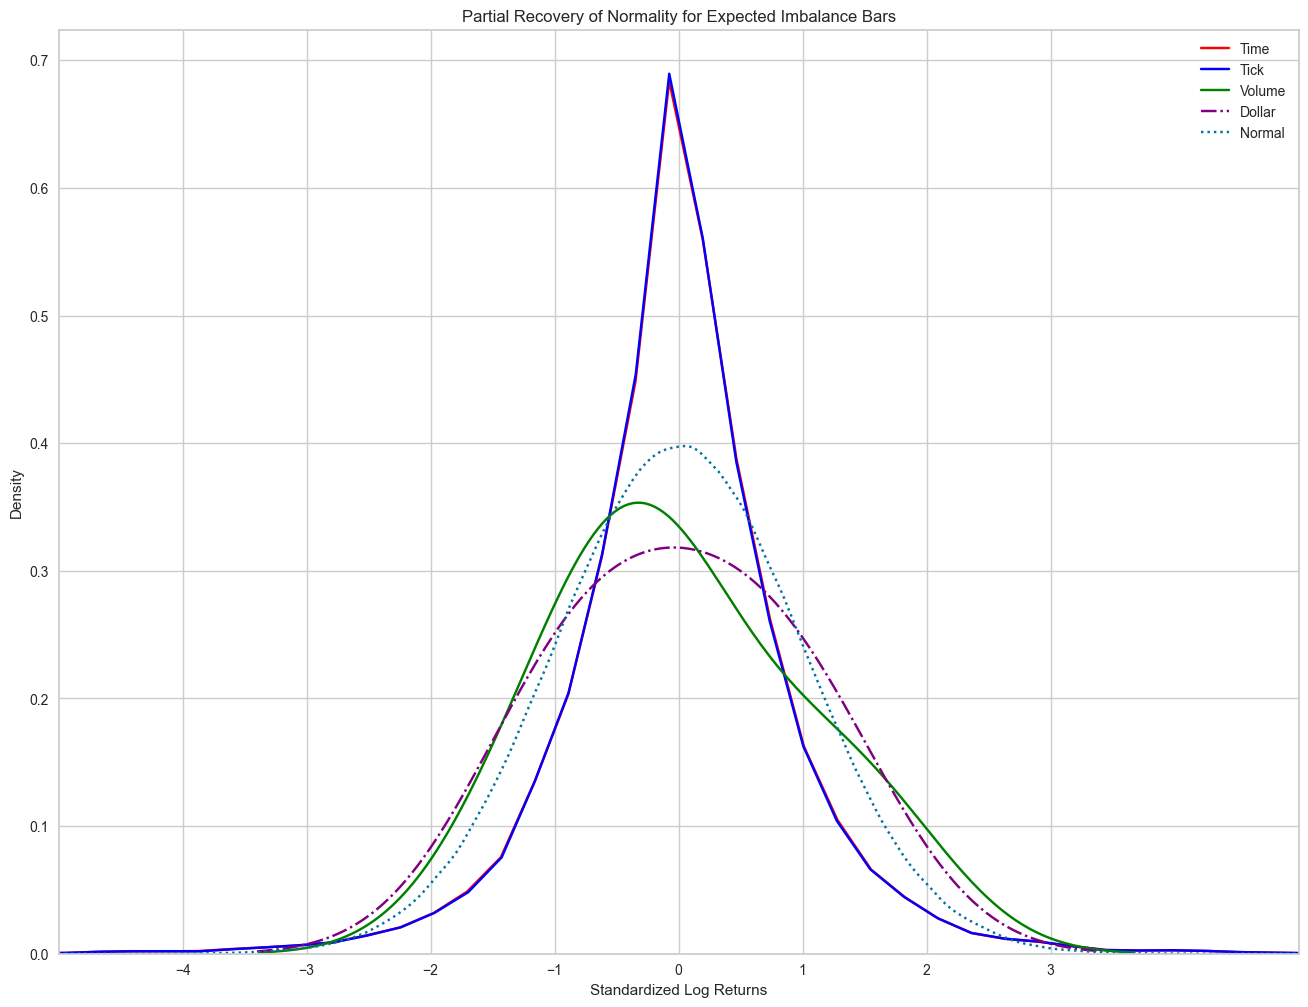

In [21]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(EIB_tick_standard, label="Tick", color="blue")
sns.kdeplot(EIB_volume_standard, label="Volume", color="green")
sns.kdeplot(EIB_dollar_standard, label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Expected Imbalance Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

## Run Bars

### Tick Run Bars

In [22]:
tick_run_bars = controller.handle_input_command(
    method_name="expected_tick_run_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 240, #5
        "window_size_for_expected_imbalance_estimation": 1460, #10000
        "initial_estimate_of_expected_n_ticks_in_bar": 7450, #20000
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

tick_run_bars_with_orderbook = attach_extra_features_to_bars(
    df,
    tick_run_bars,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

tick_run_bars_with_orderbook.head()
tick_run_bars.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Volume Run Bars

In [23]:


volume_run_bars = controller.handle_input_command(
    method_name="expected_volume_run_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 50, #5
        "window_size_for_expected_imbalance_estimation": 2000, #10000
        "initial_estimate_of_expected_n_ticks_in_bar": 200, #20000
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

volume_run_bars_with_orderbook = attach_extra_features_to_bars(
    df,
    volume_run_bars,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

volume_run_bars_with_orderbook.head()
volume_run_bars.head()



Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Dollar Run Bars

In [24]:
dollar_run_bars = controller.handle_input_command(
    method_name="expected_dollar_run_bars",
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": 100, #5
        "window_size_for_expected_imbalance_estimation": 1000, #10000
        "initial_estimate_of_expected_n_ticks_in_bar": 500, #20000
    },
    input_data=data,
    batch_size=1_000_000,
)

#Map / Aggreagate to other features

dollar_run_bars_with_orderbook = attach_extra_features_to_bars(
    df,
    dollar_run_bars,
    feature_cols=features,
    # optional overrides:
    # agg_spec={"spot_price": "mean"},  # if you want different aggregation
    # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
    drop_empty=False
)

dollar_run_bars_with_orderbook.head()
dollar_run_bars.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-18 16:14:13.902734+00:00,1052,118251.351562,118316.007812,114860.632812,116105.218750,2830.342428,1022.983949,1807.358479,1052,3.307344e+08,9.568615e+07
1,2025-08-19 05:22:42.302656+00:00,1840,116085.093750,116971.796875,114574.507812,115203.500000,3217.823147,1473.979896,1743.843251,788,3.723097e+08,2.013237e+08
2,2025-08-19 21:31:16.862652+00:00,2808,115167.851562,115868.000000,112767.070312,113524.906250,4256.485605,2142.838610,2113.646996,968,4.886430e+08,2.459701e+08
3,2025-08-20 11:08:45.712661+00:00,3625,113516.007812,114016.460938,112620.218750,113738.156250,3908.332325,1918.811475,1989.520850,817,4.434084e+08,2.255656e+08
4,2025-08-20 16:03:56.502657+00:00,3920,113686.796875,114314.859375,112398.906250,113394.007812,4493.737676,2214.641060,2279.096616,295,5.098097e+08,2.572220e+08


### Statistical Test

#### Log Return

In [25]:
tick_run_bars_returns = log_return(tick_run_bars['Close'])
volume_run_bars_returns = log_return(volume_run_bars['Close'])
dollar_run_bars_returns = log_return(dollar_run_bars['Close'])

####  Jarque–Bera test statistic 

In [26]:
print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
print("Jarque-Bera test statistic for tick run bars returns:", int(stats.jarque_bera(tick_run_bars_returns)[0]))
print("Jarque-Bera test statistic for volume run bars returns:", int(stats.jarque_bera(volume_run_bars_returns)[0]))
print("Jarque-Bera test statistic for dollar run bars returns:", int(stats.jarque_bera(dollar_run_bars_returns)[0]))

Jarque-Bera test statistic for time returns: 6474885


ValueError: At least one observation is required.

#### Shapiro-Wilk Test

In [ ]:
print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
print("Shapiro-Wilk test statistic for tick run bars returns:", stats.shapiro(tick_run_bars_returns))
print("Shapiro-Wilk test statistic for volume run bars returns:", stats.shapiro(volume_run_bars_returns))
print("Shapiro-Wilk test statistic for dollar run bars returns:", stats.shapiro(dollar_run_bars_returns))

#### Kernel Density Estimate (KDE) plot

In [ ]:
#Standardize Data 
tick_run_bars_standard = (tick_run_bars_returns - tick_run_bars_returns.mean()) / tick_run_bars_returns.std()
volume_run_bars_standard = (volume_run_bars_returns  - volume_run_bars_returns.mean()) / volume_run_bars_returns.std()
dollar_run_bars_standard = (dollar_run_bars_returns - dollar_run_bars_returns.mean()) / dollar_run_bars_returns.std()

In [ ]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(tick_run_bars_standard, label="Tick", color="blue")
sns.kdeplot(volume_run_bars_standard, label="Volume", color="green")
sns.kdeplot(dollar_run_bars_standard , label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Run Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

# Conclustion

# Future Studies

In [27]:
def objective(trial):
    # Hyperparameters to tune
    param = {
        "window_size_for_expected_n_ticks_estimation": trial.suggest_int("window_size_for_expected_n_ticks_estimation", 1, 50),
        "window_size_for_expected_imbalance_estimation": trial.suggest_int("window_size_for_expected_imbalance_estimation", 100, 20000),
        "initial_estimate_of_expected_n_ticks_in_bar": trial.suggest_int("initial_estimate_of_expected_n_ticks_in_bar", 500, 5000),
         # or log-scale (Optuna ≥3 supports log for suggest_int)
        "batch_size": trial.suggest_int("batch_size", 50_000, 2_000_000, log=True)
    }

    # Generate imbalance bars
    EIB_dollar = controller.handle_input_command(
        method_name="expected_dollar_imbalance_bars",
        method_arguments={
            "window_size_for_expected_n_ticks_estimation": param["window_size_for_expected_n_ticks_estimation"],
            "window_size_for_expected_imbalance_estimation": param["window_size_for_expected_imbalance_estimation"],
            "initial_estimate_of_expected_n_ticks_in_bar": param["initial_estimate_of_expected_n_ticks_in_bar"],
        },
        input_data=data,
        batch_size=param["batch_size"],
    )

    # Compute returns from EIB_dollar (you need to replace with your actual logic)
    dollars_EIB_returns = log_return(EIB_dollar['Close'])

    # Shapiro-Wilk test
    #minimum 3 datapoints
    # --- Guardrails for Shapiro ---
    # too few points → either prune or penalize
    if dollars_EIB_returns .size < 3:
        # Prefer pruning so Optuna doesn’t waste time on bad regions:
        raise optuna.TrialPruned("Not enough data points for Shapiro (need >= 3).")
        # or alternatively: return 1.0  # penalty

    # zero variance also breaks normality tests
    if np.allclose(np.var(dollars_EIB_returns ), 0.0):
        raise optuna.TrialPruned("Zero-variance returns.")

    # Shapiro recommended max n=5000; subsample if larger
    if dollars_EIB_returns .size > 5000:
        rng = np.random.default_rng(42)
        idx = rng.choice(dollars_EIB_returns .size, size=5000, replace=False)
        sample = dollars_EIB_returns [idx]
    else:
        sample = dollars_EIB_returns 

    # --- Shapiro–Wilk test ---
    # We want "more normal" = better → maximize statistic (close to 1).
    # Optuna minimizes by default, so we return (1 - stat).
    try:
        stat, pval = stats.shapiro(sample)
    except ValueError as e:
        # e.g., numerical issues → prune this trial
        raise optuna.TrialPruned(f"Shapiro failed: {e}")

    # Store extra values for later inspection
    trial.set_user_attr("shapiro_stat", float(stat))
    trial.set_user_attr("shapiro_pval", float(pval))

    # Optimize based on stat (closer to 1 is better)
    return 1.0 - float(stat)  # lower is better (stat closer to 1)

In [28]:
study = optuna.create_study(direction="minimize")  # minimize 1 - stat
study.optimize(objective, n_trials=50)

[I 2025-09-08 12:02:12,720] A new study created in memory with name: no-name-41d8b584-6f60-4c61-9d22-154d6f86b22c
[I 2025-09-08 12:02:12,851] Trial 0 finished with value: 0.16643202304840088 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 3757, 'initial_estimate_of_expected_n_ticks_in_bar': 1130, 'batch_size': 74065}. Best is trial 0 with value: 0.16643202304840088.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:02:14,277] Trial 1 finished with value: 0.13303536176681519 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 2217, 'initial_estimate_of_expected_n_ticks_in_bar': 3464, 'batch_size': 279368}. Best is trial 1 with value: 0.13303536176681519.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:18,010] Trial 2 finished with value: 0.2501811385154724 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 6589, 'initial_estimate_of_expected_n_ticks_in_bar': 1092, 'batch_size': 73673}. Best is trial 1 with value: 0.13303536176681519.
[I 2025-09-08 12:02:18,133] Trial 3 finished with value: 0.008773744106292725 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 2506, 'initial_estimate_of_expected_n_ticks_in_bar': 772, 'batch_size': 564300}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:02:21,561] Trial 4 finished with value: 0.1765056848526001 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 6725, 'initial_estimate_of_expected_n_ticks_in_bar': 1232, 'batch_size': 65803}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:29,874] Trial 5 finished with value: 0.25322258472442627 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 18101, 'initial_estimate_of_expected_n_ticks_in_bar': 1172, 'batch_size': 192032}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:37,856] Trial 6 finished with value: 0.2225484848022461 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 18254, 'initial_estimate_of_expected_n_ticks_in_bar': 3045, 'batch_size': 151689}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:45,045] Trial 7 finished with value: 0.19778692722320557 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 16278, 'initial_estimate_of_expected_n_ticks_in_bar': 4296, 'batch_size': 1778500}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:46,171] Trial 8 finished with value: 0.7958703637123108 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 15401, 'initial_estimate_of_expected_n_ticks_in_bar': 4574, 'batch_size': 1507158}. Best is trial 3 with value: 0.008773744106292725.
[I 2025-09-08 12:02:46,294] Trial 9 finished with value: 0.08552658557891846 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 4535, 'initial_estimate_of_expected_n_ticks_in_bar': 1347, 'batch_size': 1605800}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:02:46,532] Trial 10 finished with value: 0.08977508544921875 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 11417, 'initial_estimate_of_expected_n_ticks_in_bar': 2114, 'batch_size': 623388}. Best is trial 3 with value: 0.008773744106292725.
[I 2025-09-08 12:02:46,661] Trial 11 finished with value: 0.16853642463684082 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 336, 'initial_estimate_of_expected_n_ticks_in_bar': 528, 'batch_size': 737005}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:02:46,789] Trial 12 finished with value: 0.05159801244735718 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 5257, 'initial_estimate_of_expected_n_ticks_in_bar': 2042, 'batch_size': 803838}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:51,891] Trial 13 finished with value: 0.27427196502685547 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 9769, 'initial_estimate_of_expected_n_ticks_in_bar': 2202, 'batch_size': 599724}. Best is trial 3 with value: 0.008773744106292725.
[I 2025-09-08 12:02:52,018] Trial 14 finished with value: 0.19162356853485107 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 9336, 'initial_estimate_of_expected_n_ticks_in_bar': 2111, 'batch_size': 924197}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:02:52,258] Trial 15 finished with value: 0.04627728462219238 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 159, 'initial_estimate_of_expected_n_ticks_in_bar': 540, 'batch_size': 388665}. Best is trial 3 with value: 0.008773744106292725.
[I 2025-09-08 12:02:52,384] Trial 16 finished with value: 0.2528630495071411 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 481, 'initial_estimate_of_expected_n_ticks_in_bar': 575, 'batch_size': 352184}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:02:52,515] Trial 17 finished with value: 0.05941343307495117 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 2270, 'initial_estimate_of_expected_n_ticks_in_bar': 1550, 'batch_size': 360139}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:54,579] Trial 18 finished with value: 0.7494527697563171 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 12336, 'initial_estimate_of_expected_n_ticks_in_bar': 3765, 'batch_size': 131208}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:59,144] Trial 19 finished with value: 0.2365666627883911 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 7862, 'initial_estimate_of_expected_n_ticks_in_bar': 555, 'batch_size': 466770}. Best is trial 3 with value: 0.008773744106292725.


Processing batch 0 with size 29401


[I 2025-09-08 12:02:59,382] Trial 20 finished with value: 0.0001341700553894043 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2403, 'initial_estimate_of_expected_n_ticks_in_bar': 2817, 'batch_size': 234273}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:02:59,511] Trial 21 finished with value: 0.0018804669380187988 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2815, 'initial_estimate_of_expected_n_ticks_in_bar': 2636, 'batch_size': 243088}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:02:59,641] Trial 22 finished with value: 0.010903239250183105 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 2436, 'initial_estimate_of_expected_n_ticks_in_bar': 2643, 'batch_size': 236317}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:02:59,768] Trial 23 finished with value: 0.0029355287551879883 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 3294, 'initial_estimate_of_expected_n_ticks_in_bar': 2805, 'batch_size': 114621}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:02:59,898] Trial 24 finished with value: 0.050561606884002686 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 5614, 'initial_estimate_of_expected_n_ticks_in_bar': 2723, 'batch_size': 120588}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:03:00,025] Trial 25 finished with value: 0.06827199459075928 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 3657, 'initial_estimate_of_expected_n_ticks_in_bar': 3164, 'batch_size': 99680}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:00,267] Trial 26 finished with value: 0.08403152227401733 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 8299, 'initial_estimate_of_expected_n_ticks_in_bar': 3774, 'batch_size': 187484}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:03:00,396] Trial 27 finished with value: 0.08438628911972046 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 3576, 'initial_estimate_of_expected_n_ticks_in_bar': 2444, 'batch_size': 92813}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:00,527] Trial 28 finished with value: 0.010102808475494385 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 1450, 'initial_estimate_of_expected_n_ticks_in_bar': 3111, 'batch_size': 51021}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:03:00,654] Trial 29 finished with value: 0.08229440450668335 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 4628, 'initial_estimate_of_expected_n_ticks_in_bar': 3551, 'batch_size': 231815}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:04,087] Trial 30 finished with value: 0.23908007144927979 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 6416, 'initial_estimate_of_expected_n_ticks_in_bar': 1748, 'batch_size': 171677}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401


[I 2025-09-08 12:03:04,314] Trial 31 finished with value: 0.0030672550201416016 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 3077, 'initial_estimate_of_expected_n_ticks_in_bar': 2421, 'batch_size': 274080}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:03:04,443] Trial 32 finished with value: 0.05183154344558716 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 3582, 'initial_estimate_of_expected_n_ticks_in_bar': 2513, 'batch_size': 275714}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:04,572] Trial 33 finished with value: 0.0002664923667907715 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1682, 'initial_estimate_of_expected_n_ticks_in_bar': 2963, 'batch_size': 275697}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:03:04,700] Trial 34 finished with value: 0.01326298713684082 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 1869, 'initial_estimate_of_expected_n_ticks_in_bar': 2960, 'batch_size': 230520}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:04,829] Trial 35 finished with value: 0.04928171634674072 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 1158, 'initial_estimate_of_expected_n_ticks_in_bar': 3462, 'batch_size': 426063}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:03:04,957] Trial 36 finished with value: 0.12543779611587524 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 5016, 'initial_estimate_of_expected_n_ticks_in_bar': 2841, 'batch_size': 112927}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:05,202] Trial 37 finished with value: 0.082760751247406 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 1496, 'initial_estimate_of_expected_n_ticks_in_bar': 3399, 'batch_size': 159996}. Best is trial 20 with value: 0.0001341700553894043.


Processing batch 0 with size 29401


[I 2025-09-08 12:03:08,786] Trial 38 finished with value: 0.19252127408981323 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 6797, 'initial_estimate_of_expected_n_ticks_in_bar': 4055, 'batch_size': 80306}. Best is trial 20 with value: 0.0001341700553894043.
[I 2025-09-08 12:03:08,914] Trial 39 finished with value: 3.5762786865234375e-07 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 2890, 'initial_estimate_of_expected_n_ticks_in_bar': 3239, 'batch_size': 143312}. Best is trial 39 with value: 3.5762786865234375e-07.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:11,176] Trial 40 finished with value: 0.7012242078781128 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 13789, 'initial_estimate_of_expected_n_ticks_in_bar': 4882, 'batch_size': 213511}. Best is trial 39 with value: 3.5762786865234375e-07.


Processing batch 0 with size 29401


[I 2025-09-08 12:03:11,434] Trial 41 finished with value: 0.0016177892684936523 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 3020, 'initial_estimate_of_expected_n_ticks_in_bar': 3293, 'batch_size': 299177}. Best is trial 39 with value: 3.5762786865234375e-07.


Processing batch 0 with size 29401


[I 2025-09-08 12:03:19,910] Trial 42 finished with value: 0.17880213260650635 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 19550, 'initial_estimate_of_expected_n_ticks_in_bar': 3307, 'batch_size': 294157}. Best is trial 39 with value: 3.5762786865234375e-07.
[I 2025-09-08 12:03:20,041] Trial 43 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:20,172] Trial 44 finished with value: 0.0016791820526123047 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 2672, 'initial_estimate_of_expected_n_ticks_in_bar': 3173, 'batch_size': 143927}. Best is trial 39 with value: 3.5762786865234375e-07.


Processing batch 0 with size 29401


[I 2025-09-08 12:03:21,334] Trial 45 finished with value: 0.6406065225601196 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 6018, 'initial_estimate_of_expected_n_ticks_in_bar': 3159, 'batch_size': 144107}. Best is trial 39 with value: 3.5762786865234375e-07.


Processing batch 0 with size 29401


[I 2025-09-08 12:03:21,564] Trial 46 finished with value: 0.0320889949798584 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 1136, 'initial_estimate_of_expected_n_ticks_in_bar': 3668, 'batch_size': 184478}. Best is trial 39 with value: 3.5762786865234375e-07.


Processing batch 0 with size 29401


[I 2025-09-08 12:03:25,624] Trial 47 finished with value: 0.14102166891098022 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 7426, 'initial_estimate_of_expected_n_ticks_in_bar': 4142, 'batch_size': 148696}. Best is trial 39 with value: 3.5762786865234375e-07.
[I 2025-09-08 12:03:25,753] Trial 48 finished with value: 0.05040019750595093 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 4202, 'initial_estimate_of_expected_n_ticks_in_bar': 3271, 'batch_size': 321753}. Best is trial 39 with value: 3.5762786865234375e-07.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:03:25,884] Trial 49 finished with value: 9.28640365600586e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 2469, 'initial_estimate_of_expected_n_ticks_in_bar': 2964, 'batch_size': 201777}. Best is trial 39 with value: 3.5762786865234375e-07.


In [41]:
print("Best params:", study.best_params)
print("Best score:", study.best_value)
# Access the best trial's values
best = study.best_trial
print("Best stat:", best.user_attrs["shapiro_stat"])
print("Best p-value:", best.user_attrs["shapiro_pval"])

Best params: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 2890, 'initial_estimate_of_expected_n_ticks_in_bar': 3239, 'batch_size': 143312}
Best score: 3.5762786865234375e-07
Best stat: 0.9999996423721313
Best p-value: 0.9988578659457413


In [ ]:
Imbalance_sampling_method = ["expected_tick_imbalance_bars", "expected_volume_imbalance_bars", "expected_dollar_imbalance_bars"]
run_bars_sampling_method  = ["expected_tick_run_bars", "expected_volume_run_bars", "expected_dollar_run_bars"]

def sampling_best_params(sampling_method, df_sample, trials=50):

    def objective(trial):
        # Hyperparameters to tune
        param = {
            "window_size_for_expected_n_ticks_estimation": trial.suggest_int("window_size_for_expected_n_ticks_estimation", 1, 50),
            "window_size_for_expected_imbalance_estimation": trial.suggest_int("window_size_for_expected_imbalance_estimation", 100, 20000),
            "initial_estimate_of_expected_n_ticks_in_bar": trial.suggest_int("initial_estimate_of_expected_n_ticks_in_bar", 500, 5000),
            # or log-scale (Optuna ≥3 supports log for suggest_int)
            "batch_size": trial.suggest_int("batch_size", 50_000, 2_000_000, log=True)
        }

        # Generate imbalance bars
        info_driven_bar = controller.handle_input_command(
            method_name=sampling_method,
            method_arguments={
                "window_size_for_expected_n_ticks_estimation": param["window_size_for_expected_n_ticks_estimation"],
                "window_size_for_expected_imbalance_estimation": param["window_size_for_expected_imbalance_estimation"],
                "initial_estimate_of_expected_n_ticks_in_bar": param["initial_estimate_of_expected_n_ticks_in_bar"],
            },
            input_data=df_sample,
            batch_size=param["batch_size"],
        )

        # Compute returns from info_driven_bar
        info_driven_bar_returns = log_return(info_driven_bar['Close'])

        # Shapiro-Wilk test
        #minimum 3 datapoints
        # --- Guardrails for Shapiro ---
        # too few points → either prune or penalize
        if info_driven_bar_returns.size < 3:
            # Prefer pruning so Optuna doesn’t waste time on bad regions:
            raise optuna.TrialPruned("Not enough data points for Shapiro (need >= 3).")
            # or alternatively: return 1.0  # penalty

        # zero variance also breaks normality tests
        if np.allclose(np.var(info_driven_bar_returns ), 0.0):
            raise optuna.TrialPruned("Zero-variance returns.")

        # Shapiro recommended max n=5000; subsample if larger
        if info_driven_bar_returns.size > 5000:
            rng = np.random.default_rng(42)
            idx = rng.choice(info_driven_bar_returns.size, size=5000, replace=False)
            sample = info_driven_bar_returns[idx]
        else:
            sample = info_driven_bar_returns

        # --- Shapiro–Wilk test ---
        # We want "more normal" = better → maximize statistic (close to 1).
        # Optuna minimizes by default, so we return (1 - stat).
        try:
            stat, pval = stats.shapiro(sample)
        except ValueError as e:
            # e.g., numerical issues → prune this trial
            raise optuna.TrialPruned(f"Shapiro failed: {e}")

        # Store extra values for later inspection
        trial.set_user_attr("shapiro_stat", float(stat))
        trial.set_user_attr("shapiro_pval", float(pval))

        # Optimize based on stat (closer to 1 is better)
        return 1.0 - float(stat)  # lower is better (stat closer to 1)

    study = optuna.create_study(direction="minimize")  # minimize 1 - stat
    study.optimize(objective, n_trials=trials)

    new_params = {  'n_trials' : trials,
                    'best score': study.best_value,
                    'Best stat': best.user_attrs.get('shapiro_stat'),
                    'Best p-value': best.user_attrs.get('shapiro_pval'),
                } | study.best_params 
    
    return new_params

SyntaxError: invalid syntax (1097751672.py, line 72)

In [53]:
x = "expected_dollar_imbalance_bars"
y = data

best_params = sampling_best_params(sampling_method=x, df_sample=y, trials=50)

[I 2025-09-08 12:37:48,982] A new study created in memory with name: no-name-7c58c1a1-110b-4d19-9ec2-96a57e1b3672


Processing batch 0 with size 29401


[I 2025-09-08 12:37:54,172] Trial 0 finished with value: 0.13867008686065674 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 9197, 'initial_estimate_of_expected_n_ticks_in_bar': 4698, 'batch_size': 99672}. Best is trial 0 with value: 0.13867008686065674.


Processing batch 0 with size 29401


[I 2025-09-08 12:37:54,700] Trial 1 finished with value: 0.7931448221206665 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 4618, 'initial_estimate_of_expected_n_ticks_in_bar': 1219, 'batch_size': 405981}. Best is trial 0 with value: 0.13867008686065674.
[I 2025-09-08 12:37:54,823] Trial 2 finished with value: 0.04930746555328369 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 1699, 'initial_estimate_of_expected_n_ticks_in_bar': 3181, 'batch_size': 1651972}. Best is trial 2 with value: 0.04930746555328369.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:37:56,530] Trial 3 finished with value: 0.5618007779121399 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 8221, 'initial_estimate_of_expected_n_ticks_in_bar': 4831, 'batch_size': 492968}. Best is trial 2 with value: 0.04930746555328369.
[I 2025-09-08 12:37:56,653] Trial 4 finished with value: 0.03810405731201172 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 5431, 'initial_estimate_of_expected_n_ticks_in_bar': 2589, 'batch_size': 1261473}. Best is trial 4 with value: 0.03810405731201172.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:01,489] Trial 5 finished with value: 0.17696505784988403 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 8442, 'initial_estimate_of_expected_n_ticks_in_bar': 1597, 'batch_size': 459219}. Best is trial 4 with value: 0.03810405731201172.


Processing batch 0 with size 29401


[I 2025-09-08 12:38:07,979] Trial 6 finished with value: 0.1570776104927063 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 13584, 'initial_estimate_of_expected_n_ticks_in_bar': 1375, 'batch_size': 79132}. Best is trial 4 with value: 0.03810405731201172.
[I 2025-09-08 12:38:08,100] Trial 7 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-08 12:38:08,224] Trial 8 finished with value: 0.1313415765762329 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 10985, 'initial_estimate_of_expected_n_ticks_in_bar': 3433, 'batch_size': 903420}. Best is trial 4 with value: 0.03810405731201172.


Processing batch 0 with size 29401
Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:09,353] Trial 9 finished with value: 0.7139129042625427 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 7525, 'initial_estimate_of_expected_n_ticks_in_bar': 3064, 'batch_size': 884129}. Best is trial 4 with value: 0.03810405731201172.


Processing batch 0 with size 29401


[I 2025-09-08 12:38:17,895] Trial 10 finished with value: 0.14431047439575195 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 18155, 'initial_estimate_of_expected_n_ticks_in_bar': 2417, 'batch_size': 172613}. Best is trial 4 with value: 0.03810405731201172.
[I 2025-09-08 12:38:18,022] Trial 11 finished with value: 0.1412205696105957 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 1332, 'initial_estimate_of_expected_n_ticks_in_bar': 3558, 'batch_size': 1935134}. Best is trial 4 with value: 0.03810405731201172.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:18,150] Trial 12 finished with value: 0.07170188426971436 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 3627, 'initial_estimate_of_expected_n_ticks_in_bar': 2422, 'batch_size': 1918772}. Best is trial 4 with value: 0.03810405731201172.


Processing batch 0 with size 29401


[I 2025-09-08 12:38:18,797] Trial 13 finished with value: 0.47978657484054565 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 4718, 'initial_estimate_of_expected_n_ticks_in_bar': 4087, 'batch_size': 1031887}. Best is trial 4 with value: 0.03810405731201172.
[I 2025-09-08 12:38:18,922] Trial 14 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:19,053] Trial 15 finished with value: 0.013848423957824707 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 6013, 'initial_estimate_of_expected_n_ticks_in_bar': 2962, 'batch_size': 217934}. Best is trial 15 with value: 0.013848423957824707.


Processing batch 0 with size 29401


[I 2025-09-08 12:38:22,044] Trial 16 finished with value: 0.15572255849838257 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 6130, 'initial_estimate_of_expected_n_ticks_in_bar': 4056, 'batch_size': 182113}. Best is trial 15 with value: 0.013848423957824707.
[I 2025-09-08 12:38:22,171] Trial 17 finished with value: 0.25140196084976196 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 11932, 'initial_estimate_of_expected_n_ticks_in_bar': 2036, 'batch_size': 235527}. Best is trial 15 with value: 0.013848423957824707.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:29,087] Trial 18 finished with value: 0.23719441890716553 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 14532, 'initial_estimate_of_expected_n_ticks_in_bar': 2755, 'batch_size': 51892}. Best is trial 15 with value: 0.013848423957824707.
[I 2025-09-08 12:38:29,214] Trial 19 finished with value: 0.12439632415771484 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 6081, 'initial_estimate_of_expected_n_ticks_in_bar': 3833, 'batch_size': 632469}. Best is trial 15 with value: 0.013848423957824707.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:37,028] Trial 20 finished with value: 0.19443923234939575 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 16968, 'initial_estimate_of_expected_n_ticks_in_bar': 2786, 'batch_size': 239702}. Best is trial 15 with value: 0.013848423957824707.
[I 2025-09-08 12:38:37,156] Trial 21 finished with value: 0.08167552947998047 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 2200, 'initial_estimate_of_expected_n_ticks_in_bar': 3157, 'batch_size': 1489424}. Best is trial 15 with value: 0.013848423957824707.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:40,496] Trial 22 finished with value: 0.13503378629684448 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 6221, 'initial_estimate_of_expected_n_ticks_in_bar': 3148, 'batch_size': 129664}. Best is trial 15 with value: 0.013848423957824707.
[I 2025-09-08 12:38:40,623] Trial 23 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:40,749] Trial 24 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-08 12:38:44,600] Trial 25 finished with value: 0.16303277015686035 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 6957, 'initial_estimate_of_expected_n_ticks_in_bar': 2740, 'batch_size': 1351640}. Best is trial 15 with value: 0.013848423957824707.


Processing batch 0 with size 29401


[I 2025-09-08 12:38:47,313] Trial 26 finished with value: 0.23715537786483765 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 4792, 'initial_estimate_of_expected_n_ticks_in_bar': 1651, 'batch_size': 669681}. Best is trial 15 with value: 0.013848423957824707.
[I 2025-09-08 12:38:47,445] Trial 27 finished with value: 0.005237877368927002 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 2255, 'initial_estimate_of_expected_n_ticks_in_bar': 4415, 'batch_size': 1582416}. Best is trial 27 with value: 0.005237877368927002.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:47,578] Trial 28 finished with value: 0.07476294040679932 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 10464, 'initial_estimate_of_expected_n_ticks_in_bar': 4383, 'batch_size': 1045908}. Best is trial 27 with value: 0.005237877368927002.


Processing batch 0 with size 29401


[I 2025-09-08 12:38:52,566] Trial 29 finished with value: 0.24041873216629028 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 9486, 'initial_estimate_of_expected_n_ticks_in_bar': 4508, 'batch_size': 88160}. Best is trial 27 with value: 0.005237877368927002.
[I 2025-09-08 12:38:52,695] Trial 30 finished with value: 0.05590081214904785 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 3237, 'initial_estimate_of_expected_n_ticks_in_bar': 4949, 'batch_size': 125071}. Best is trial 27 with value: 0.005237877368927002.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:52,949] Trial 31 finished with value: 0.009508371353149414 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 2240, 'initial_estimate_of_expected_n_ticks_in_bar': 2959, 'batch_size': 1587190}. Best is trial 27 with value: 0.005237877368927002.
[I 2025-09-08 12:38:53,079] Trial 32 finished with value: 0.051233649253845215 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 5158, 'initial_estimate_of_expected_n_ticks_in_bar': 1891, 'batch_size': 1234887}. Best is trial 27 with value: 0.005237877368927002.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:53,207] Trial 33 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-08 12:38:53,338] Trial 34 finished with value: 0.08506125211715698 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 3847, 'initial_estimate_of_expected_n_ticks_in_bar': 2582, 'batch_size': 840162}. Best is trial 27 with value: 0.005237877368927002.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:53,468] Trial 35 finished with value: 1.2636184692382812e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 1471, 'initial_estimate_of_expected_n_ticks_in_bar': 850, 'batch_size': 1525431}. Best is trial 35 with value: 1.2636184692382812e-05.
[I 2025-09-08 12:38:53,594] Trial 36 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:53,845] Trial 37 finished with value: 0.13282722234725952 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 2708, 'initial_estimate_of_expected_n_ticks_in_bar': 1066, 'batch_size': 1600097}. Best is trial 35 with value: 1.2636184692382812e-05.
[I 2025-09-08 12:38:53,974] Trial 38 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:58,393] Trial 39 finished with value: 0.18165916204452515 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 8272, 'initial_estimate_of_expected_n_ticks_in_bar': 3350, 'batch_size': 1035466}. Best is trial 35 with value: 1.2636184692382812e-05.
[I 2025-09-08 12:38:58,520] Trial 40 finished with value: 0.23759764432907104 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 2239, 'initial_estimate_of_expected_n_ticks_in_bar': 1041, 'batch_size': 395299}. Best is trial 35 with value: 1.2636184692382812e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:38:58,650] Trial 41 finished with value: 0.029800355434417725 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 5474, 'initial_estimate_of_expected_n_ticks_in_bar': 1382, 'batch_size': 1471964}. Best is trial 35 with value: 1.2636184692382812e-05.


Processing batch 0 with size 29401


[I 2025-09-08 12:38:58,906] Trial 42 finished with value: 0.01213151216506958 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 4393, 'initial_estimate_of_expected_n_ticks_in_bar': 1444, 'batch_size': 1502784}. Best is trial 35 with value: 1.2636184692382812e-05.
[I 2025-09-08 12:38:59,035] Trial 43 finished with value: 0.013600349426269531 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 3990, 'initial_estimate_of_expected_n_ticks_in_bar': 804, 'batch_size': 1197343}. Best is trial 35 with value: 1.2636184692382812e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:39:01,392] Trial 44 finished with value: 0.2653983235359192 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 3879, 'initial_estimate_of_expected_n_ticks_in_bar': 527, 'batch_size': 1170463}. Best is trial 35 with value: 1.2636184692382812e-05.
[I 2025-09-08 12:39:01,521] Trial 45 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-08 12:39:01,650] Trial 46 finished with value: 0.20078521966934204 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 2971, 'initial_estimate_of_expected_n_ticks_in_bar': 1292, 'batch_size': 1953504}. Best is trial 35 with value: 1.2636184692382812e-05.


Processing batch 0 with size 29401


[I 2025-09-08 12:39:01,897] Trial 47 finished with value: 0.07634556293487549 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 1711, 'initial_estimate_of_expected_n_ticks_in_bar': 787, 'batch_size': 1595788}. Best is trial 35 with value: 1.2636184692382812e-05.


Processing batch 0 with size 29401


[I 2025-09-08 12:39:05,712] Trial 48 finished with value: 0.11951756477355957 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 7143, 'initial_estimate_of_expected_n_ticks_in_bar': 1521, 'batch_size': 1369332}. Best is trial 35 with value: 1.2636184692382812e-05.
[I 2025-09-08 12:39:05,840] Trial 49 finished with value: 0.00937187671661377 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 1045, 'initial_estimate_of_expected_n_ticks_in_bar': 1722, 'batch_size': 1721311}. Best is trial 35 with value: 1.2636184692382812e-05.


Processing batch 0 with size 29401


In [54]:
best_params

{'best score': 1.2636184692382812e-05,
 'Best stat': 0.9999996423721313,
 'Best p-value': 0.9988578659457413,
 'window_size_for_expected_n_ticks_estimation': 27,
 'window_size_for_expected_imbalance_estimation': 1471,
 'initial_estimate_of_expected_n_ticks_in_bar': 850,
 'batch_size': 1525431}

In [30]:
print("Best params:", )
print("Best score:", )
# Access the best trial's values
best = study.best_trial
print("Best stat:", best.user_attrs["shapiro_stat"])
print("Best p-value:", best.user_attrs["shapiro_pval"])

Best params: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 2890, 'initial_estimate_of_expected_n_ticks_in_bar': 3239, 'batch_size': 143312}
Best score: 3.5762786865234375e-07
Best stat: 0.9999996423721313
Best p-value: 0.9988578659457413


# remaining task
1, create a function that automically load the optimnize parameters

In [31]:
params

,Sampling Scheme,samples,window_size_for_expected_n_ticks_estimation,window_size_for_expected_imbalance_estimation,initial_estimate_of_expected_n_ticks_in_bar,batch_size,Shapiro-Wilk_statistic,Shapiro-Wilk_pvalue
0,imbalance bar_tick,29401,5,10000,20000,1000000,"0.8601343631744385,",0.000000
1,imbalance bar_volume,29401,5,10000,20000,1000000,0.966333091,0.870860
2,imbalance bar_dollar,29401,5,10000,20000,1000000,0.961657166,0.832820
3,run_bars_tick,29401,5,10000,20000,1000000,None,NaN
4,run_bars_volume,29401,5,10000,20000,1000000,None,NaN
5,run_bars_dollar,29401,5,10000,20000,1000000,None,NaN
6,run_bars_dollar,29401,100,1000,500,1000000,0.971702158,0.567037


In [34]:
new_params= {'samples': sample_size,
            'window_size_for_expected_n_ticks_estimation': study.best_params['window_size_for_expected_n_ticks_estimation'],
            'window_size_for_expected_imbalance_estimation': study.best_params['window_size_for_expected_imbalance_estimation'],
            'initial_estimate_of_expected_n_ticks_in_bar':study.best_params['initial_estimate_of_expected_n_ticks_in_bar'],
            'batch_size': study.best_params['batch_size'],
            'Shapiro-Wilk_statistic': best.user_attrs["shapiro_stat"],
            'Shapiro-Wilk_pvalue': best.user_attrs["shapiro_pval"], 
            }

In [35]:
## update the json file

new_params

KeyError: 1